In [1]:
from onnx.external_data_helper import uses_external_data
from torchvision.models import MobileNetV3

1+1

2

In [5]:
import os
import shutil
import random


original_dataset = "../data"
base_dir = "../data_split"
os.makedirs(base_dir, exist_ok=True)

splits = ['train', 'val', 'test']
split_ratios = [0.7, 0.2, 0.1]


classes = [d for d in os.listdir(original_dataset) if os.path.isdir(os.path.join(original_dataset, d))]

for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)


for cls in classes:
    cls_path = os.path.join(original_dataset, cls)
    images = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
    random.shuffle(images)
    n_total = len(images)

    n_train = int(split_ratios[0] * n_total)
    n_val = int(split_ratios[1] * n_total)
    n_test = n_total - n_train - n_val

    train_imgs = images[:n_train]
    val_imgs = images[n_train:n_train+n_val]
    test_imgs = images[n_train+n_val:]

    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(base_dir, 'train', cls))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(base_dir, 'val', cls))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join(base_dir, 'test', cls))

print("Dataset split completed!")


Dataset split completed!


In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [7]:

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [8]:
data_dir = "../data_split"

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=f"{data_dir}/val", transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(root=f"{data_dir}/test", transform=val_test_transforms)


In [9]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [10]:

model = models.mobilenet_v3_small(weights='IMAGENET1K_V1')


num_classes = len(train_dataset.classes)
model.classifier[3] = torch.nn.Linear(model.classifier[3].in_features, num_classes)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /home/abdulaziz/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100.0%


In [11]:
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [12]:

images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)


In [14]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Validation Accuracy: 9.63%

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.00      0.02      0.01       199
                     Pepper__bell___healthy       0.18      0.01      0.02       295
                      Potato___Early_blight       0.00      0.00      0.00       200
                       Potato___Late_blight       0.20      0.07      0.10       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.00      0.00      0.00       425
                        Tomato_Early_blight       0.00      0.00      0.00       200
                         Tomato_Late_blight       0.00      0.00      0.00       381
                           Tomato_Leaf_Mold       0.00      0.00      0.00       190
                  Tomato_Septoria_leaf_spot       0.00      0.00      0.00       354
Tomato_Spider

/home/abdulaziz/AgriWatchAI/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/abdulaziz/AgriWatchAI/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/abdulaziz/AgriWatchAI/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capi

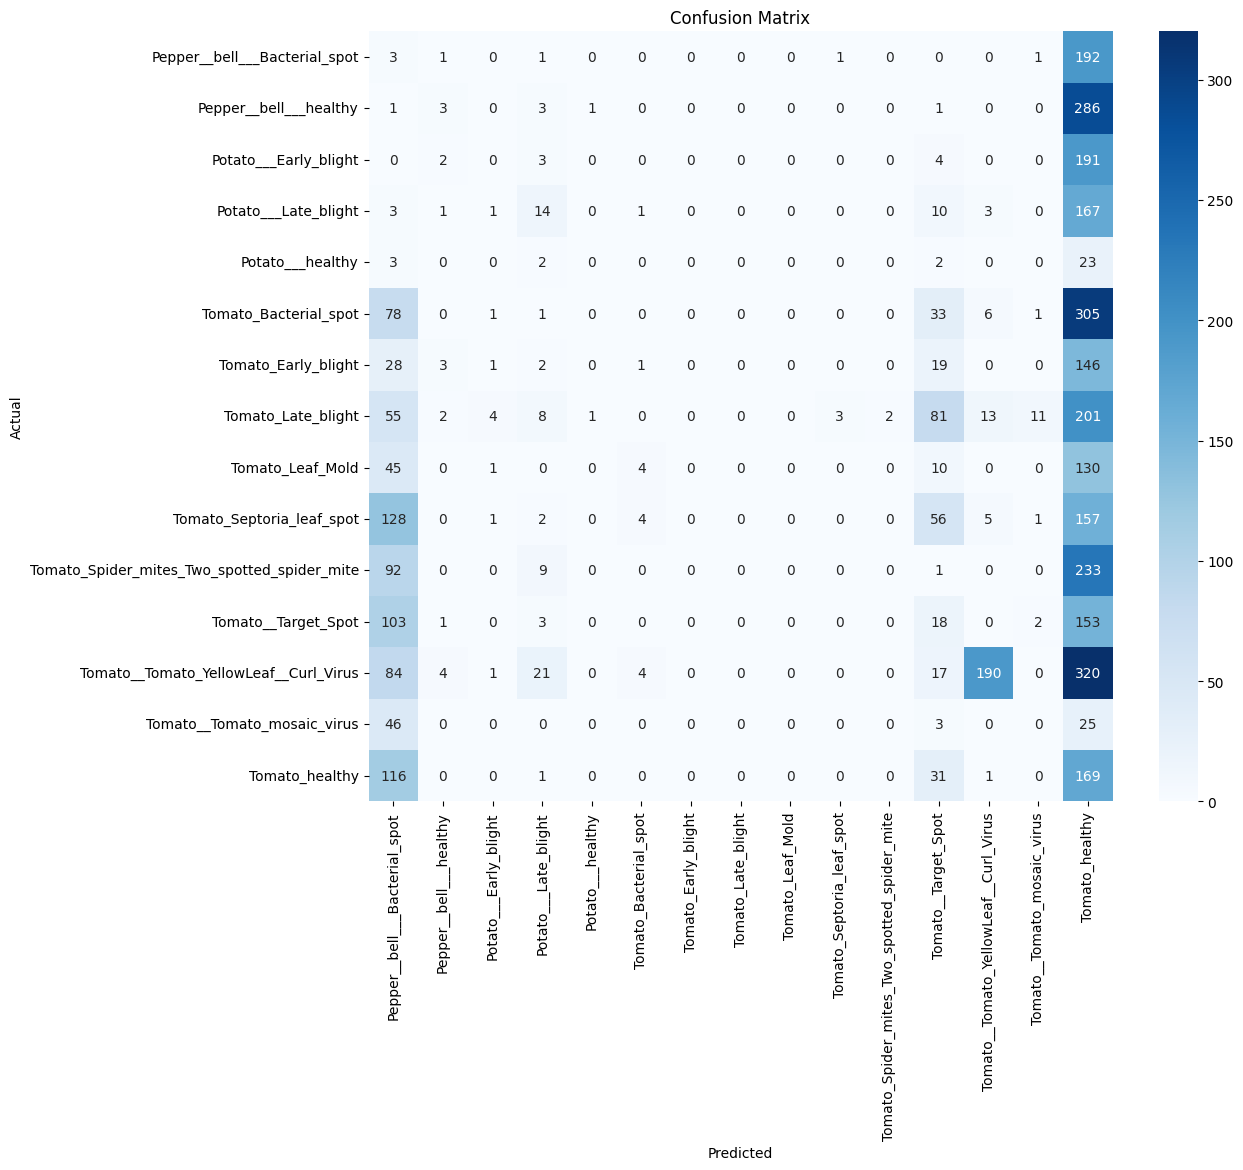

In [15]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        predictions.extend(preds.cpu().numpy())
        actuals.extend(labels.cpu().numpy())


class_names = val_dataset.classes


acc = accuracy_score(actuals, predictions)
print(f"Validation Accuracy: {acc*100:.2f}%\n")


print("Classification Report:")
print(classification_report(actuals, predictions, target_names=class_names))


cm = confusion_matrix(actuals, predictions)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [16]:
import torch
from torch import nn, optim
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


data_dir = "../data_split"
train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=f"{data_dir}/val", transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)


model = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
num_classes = len(train_dataset.classes)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)


for param in model.features.parameters():
    param.requires_grad = False

model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)


num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)


    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%")


Using device: cuda
Epoch [1/3] - Loss: 0.5648, Val Accuracy: 89.23%
Epoch [2/3] - Loss: 0.3180, Val Accuracy: 92.70%
Epoch [3/3] - Loss: 0.2555, Val Accuracy: 92.29%


Validation Accuracy: 92.29%

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       1.00      0.92      0.96       199
                     Pepper__bell___healthy       0.96      1.00      0.98       295
                      Potato___Early_blight       0.99      0.99      0.99       200
                       Potato___Late_blight       0.84      0.99      0.91       200
                           Potato___healthy       0.96      0.83      0.89        30
                      Tomato_Bacterial_spot       0.97      0.94      0.96       425
                        Tomato_Early_blight       0.96      0.62      0.76       200
                         Tomato_Late_blight       0.91      0.87      0.89       381
                           Tomato_Leaf_Mold       0.95      0.94      0.94       190
                  Tomato_Septoria_leaf_spot       0.95      0.90      0.93       354
Tomato_Spide

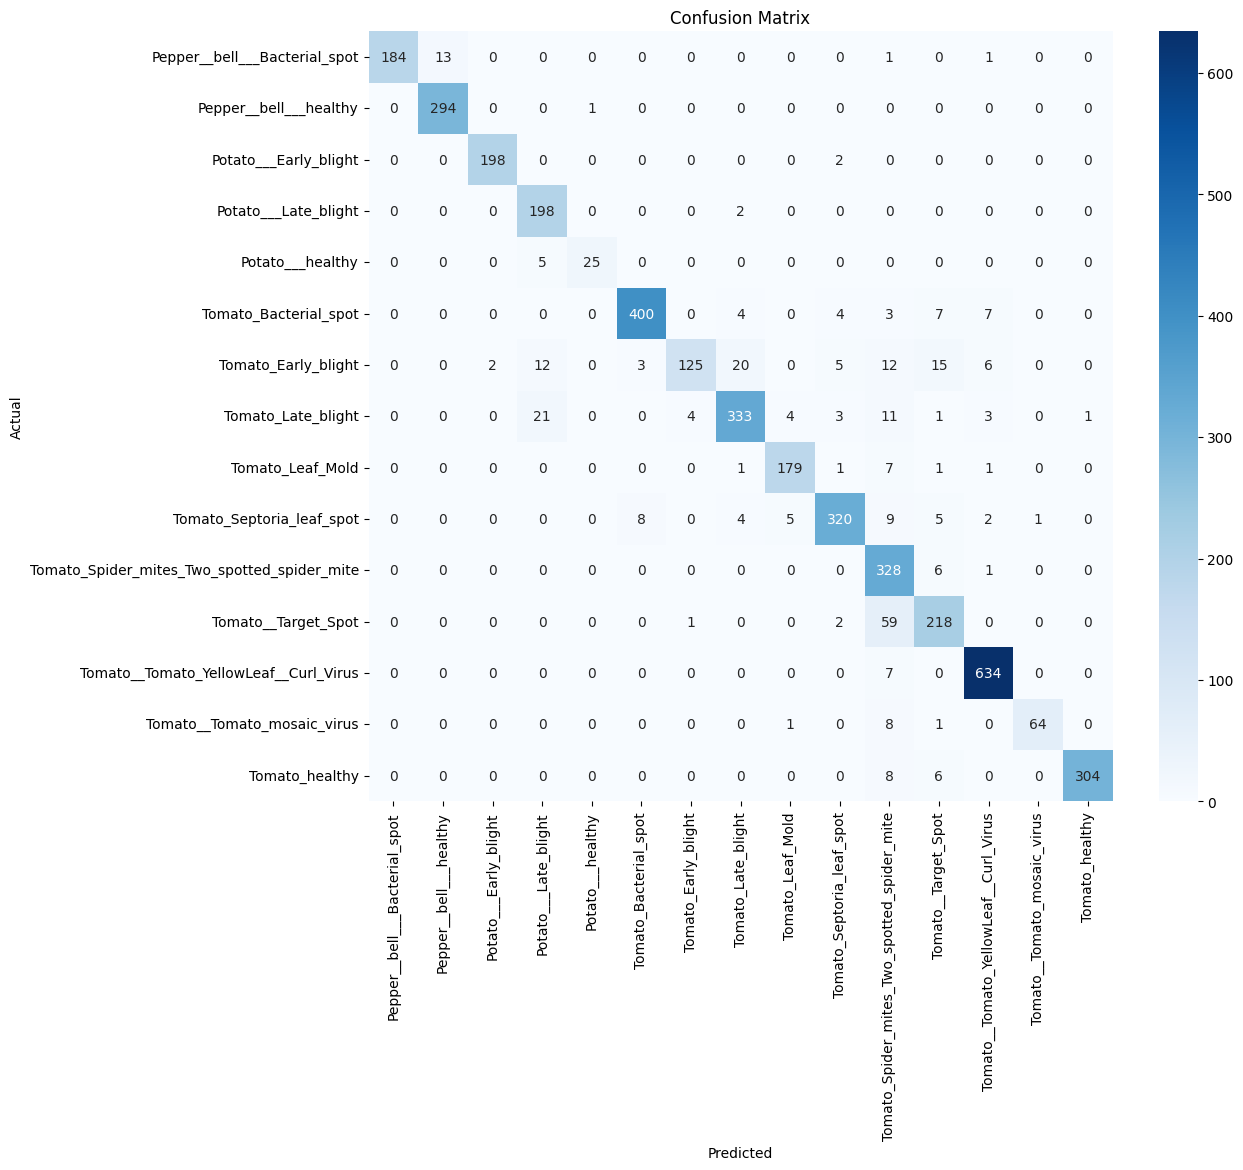

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


model.eval()

predictions = []
actuals = []


with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        predictions.extend(preds.cpu().numpy())
        actuals.extend(labels.cpu().numpy())


class_names = train_dataset.classes


acc = accuracy_score(actuals, predictions)
print(f"Validation Accuracy: {acc*100:.2f}%\n")


print("Classification Report:")
print(classification_report(actuals, predictions, target_names=class_names))


cm = confusion_matrix(actuals, predictions)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [19]:
import torch


torch.save(model.state_dict(), "../mobilenetv3_stage1.pth")
print("Stage 1 model weights saved")


Stage 1 model weights saved


In [23]:
import torch
from torch import nn, optim
from torchvision import models
from torch.quantization import get_default_qat_qconfig, prepare_qat


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model = models.mobilenet_v3_small(weights=None)
num_classes = len(train_dataset.classes)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model.load_state_dict(torch.load("../mobilenetv3_stage1.pth"))
model = model.to(device)


for param in model.features[:-5].parameters():
    param.requires_grad = False
for param in model.features[-5:].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True


qat_config = get_default_qat_qconfig('fbgemm')
model.qconfig = qat_config
prepare_qat(model, inplace=True)

model.train()


optimizer = optim.Adam([
    {'params': model.features[-5:].parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])
criterion = nn.CrossEntropyLoss()


num_epochs = 15  # adjust 10–15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)


    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%")

Using device: cuda
Epoch [1/15] - Loss: 1.1714, Val Accuracy: 37.46%
Epoch [2/15] - Loss: 0.8935, Val Accuracy: 24.07%
Epoch [3/15] - Loss: 0.7510, Val Accuracy: 26.95%
Epoch [4/15] - Loss: 0.6518, Val Accuracy: 30.42%
Epoch [5/15] - Loss: 0.6104, Val Accuracy: 26.47%
Epoch [6/15] - Loss: 0.5727, Val Accuracy: 36.07%
Epoch [7/15] - Loss: 0.5199, Val Accuracy: 33.02%
Epoch [8/15] - Loss: 0.4933, Val Accuracy: 34.89%
Epoch [9/15] - Loss: 0.4771, Val Accuracy: 30.37%
Epoch [10/15] - Loss: 0.4465, Val Accuracy: 39.50%
Epoch [11/15] - Loss: 0.4433, Val Accuracy: 35.40%
Epoch [12/15] - Loss: 0.4233, Val Accuracy: 37.46%
Epoch [13/15] - Loss: 0.3946, Val Accuracy: 33.62%
Epoch [14/15] - Loss: 0.4024, Val Accuracy: 37.99%
Epoch [15/15] - Loss: 0.3678, Val Accuracy: 41.15%


In [24]:
import torch
from torch.quantization import fuse_modules

def fuse_mobilenet_v3(model):
    """
    Fuse Conv+BN+ReLU layers in MobileNetV3 (small) for QAT.
    """
    for idx, block in enumerate(model.features):
        if isinstance(block, torch.nn.Sequential):
            for i in range(len(block)):
                if isinstance(block[i], torch.nn.Conv2d):
                    if (i + 1 < len(block)) and isinstance(block[i + 1], torch.nn.BatchNorm2d):
                        relu_idx = None
                        if (i + 2 < len(block)) and isinstance(block[i + 2], torch.nn.ReLU):
                            relu_idx = i + 2
                            fuse_modules(block, [str(i), str(i + 1), str(i + 2)], inplace=True)
                        else:
                            fuse_modules(block, [str(i), str(i + 1)], inplace=True)
    print("MobileNetV3 fused for QAT!")
    return model


In [26]:
import torch
from torchvision import models
from torch.quantization import fuse_modules, get_default_qat_qconfig, prepare_qat
from torch import nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model = models.mobilenet_v3_small(weights=None)
num_classes = len(train_dataset.classes)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model.load_state_dict(torch.load("../mobilenetv3_stage1.pth"))
model = model.to(device)


model.eval()


def fuse_mobilenet_v3(model):

    for idx, block in enumerate(model.features):
        if isinstance(block, nn.Sequential):
            for i in range(len(block)):
                if isinstance(block[i], nn.Conv2d):
                    if (i + 1 < len(block)) and isinstance(block[i + 1], nn.BatchNorm2d):
                        if (i + 2 < len(block)) and isinstance(block[i + 2], nn.ReLU):
                            fuse_modules(block, [str(i), str(i + 1), str(i + 2)], inplace=True)
                        else:
                            fuse_modules(block, [str(i), str(i + 1)], inplace=True)
    print(" MobileNetV3 fused for QAT")
    return model


model = fuse_mobilenet_v3(model)


qat_config = get_default_qat_qconfig('fbgemm')
model.qconfig = qat_config
prepare_qat(model, inplace=True)

print(" Model is fused and prepared for QAT, ready to start Stage 2 training")


Using device: cuda
✅ MobileNetV3 fused for QAT


AssertionError: prepare_qat only works on models in training mode

In [31]:
import torch
from torchvision import models
from torch.quantization import fuse_modules, get_default_qat_qconfig, prepare_qat
from torch import nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)



model = models.mobilenet_v3_small(weights=None)
num_classes = len(train_dataset.classes)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model.load_state_dict(torch.load("../mobilenetv3_stage1.pth"))
model = model.to(device)


model.eval()

def fuse_mobilenet_v3(model):

    for idx, block in enumerate(model.features):
        if isinstance(block, nn.Sequential):
            for i in range(len(block)):
                if isinstance(block[i], nn.Conv2d):
                    if (i + 1 < len(block)) and isinstance(block[i + 1], nn.BatchNorm2d):
                        if (i + 2 < len(block)) and isinstance(block[i + 2], nn.ReLU):
                            fuse_modules(block, [str(i), str(i + 1), str(i + 2)], inplace=True)
                        else:
                            fuse_modules(block, [str(i), str(i + 1)], inplace=True)
    print(" MobileNetV3 fused for QAT")
    return model

model = fuse_mobilenet_v3(model)


model.train()
qat_config = get_default_qat_qconfig('fbgemm')
model.qconfig = qat_config
prepare_qat(model, inplace=True)

print(" Model is fused and prepared for QAT, ready to start Stage 2 training")


Using device: cuda
✅ MobileNetV3 fused for QAT
✅ Model is fused and prepared for QAT, ready to start Stage 2 training


In [32]:
import torch
from torch import nn, optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


for param in model.features[:-10].parameters():
    param.requires_grad = False
for param in model.features[-10:].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True


optimizer = optim.Adam([
    {'params': model.features[-10:].parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])
criterion = nn.CrossEntropyLoss()


num_epochs = 12
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)


    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%")


Using device: cuda
Epoch [1/12] - Loss: 0.9435, Val Accuracy: 33.45%
Epoch [2/12] - Loss: 0.6029, Val Accuracy: 44.78%
Epoch [3/12] - Loss: 0.4540, Val Accuracy: 50.92%
Epoch [4/12] - Loss: 0.3797, Val Accuracy: 50.19%
Epoch [5/12] - Loss: 0.3262, Val Accuracy: 53.08%
Epoch [6/12] - Loss: 0.2746, Val Accuracy: 57.35%
Epoch [7/12] - Loss: 0.2522, Val Accuracy: 58.76%
Epoch [8/12] - Loss: 0.2193, Val Accuracy: 63.05%
Epoch [9/12] - Loss: 0.2013, Val Accuracy: 63.93%
Epoch [10/12] - Loss: 0.1833, Val Accuracy: 67.37%
Epoch [11/12] - Loss: 0.1693, Val Accuracy: 59.10%
Epoch [12/12] - Loss: 0.1705, Val Accuracy: 65.87%


In [33]:

torch.save(model.state_dict(), "mobilenetv3_stage2_qat.pth")
print(" Stage 2 QAT model saved")


 Stage 2 QAT model saved


In [34]:
model.load_state_dict(torch.load("mobilenetv3_stage2_qat.pth"))

<All keys matched successfully>

In [36]:

model = models.mobilenet_v3_small(weights=None)
num_classes = len(train_dataset.classes)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

model.eval()
model = fuse_mobilenet_v3(model)
model.train()
qat_config = get_default_qat_qconfig('fbgemm')
model.qconfig = qat_config
prepare_qat(model, inplace=True)


model.load_state_dict(torch.load("mobilenetv3_stage2_qat.pth"))
model = model.to(device)

✅ MobileNetV3 fused for QAT


In [37]:
import torch
from torch import nn, optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


for param in model.features[:-10].parameters():
    param.requires_grad = False
for param in model.features[-10:].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True


optimizer = optim.Adam([
    {'params': model.features[-10:].parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])
criterion = nn.CrossEntropyLoss()


num_epochs = 12  # adjust 10–15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)


    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%")


Using device: cuda
Epoch [1/12] - Loss: 0.1502, Val Accuracy: 58.59%
Epoch [2/12] - Loss: 0.1549, Val Accuracy: 58.49%
Epoch [3/12] - Loss: 0.1311, Val Accuracy: 63.61%
Epoch [4/12] - Loss: 0.1328, Val Accuracy: 66.01%
Epoch [5/12] - Loss: 0.1258, Val Accuracy: 67.05%
Epoch [6/12] - Loss: 0.1153, Val Accuracy: 64.07%
Epoch [7/12] - Loss: 0.1088, Val Accuracy: 67.47%
Epoch [8/12] - Loss: 0.1008, Val Accuracy: 67.56%
Epoch [9/12] - Loss: 0.0959, Val Accuracy: 69.63%
Epoch [10/12] - Loss: 0.0944, Val Accuracy: 72.34%
Epoch [11/12] - Loss: 0.0976, Val Accuracy: 71.37%
Epoch [12/12] - Loss: 0.0871, Val Accuracy: 65.67%


In [38]:
torch.save(model.state_dict(), "mobilenetv3_stage3_qat.pth")
print(" Stage 3 QAT model saved")

 Stage 3 QAT model saved


In [39]:
model.load_state_dict(torch.load("mobilenetv3_stage3_qat.pth"))


<All keys matched successfully>

In [40]:

model = models.mobilenet_v3_small(weights=None)
num_classes = len(train_dataset.classes)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

model.eval()
model = fuse_mobilenet_v3(model)
model.train()
qat_config = get_default_qat_qconfig('fbgemm')
model.qconfig = qat_config
prepare_qat(model, inplace=True)


model.load_state_dict(torch.load("mobilenetv3_stage3_qat.pth"))
model = model.to(device)

✅ MobileNetV3 fused for QAT


In [41]:
import torch
from torch import nn, optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


for param in model.features[:-12].parameters():
    param.requires_grad = False
for param in model.features[-12:].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True


optimizer = optim.Adam([
    {'params': model.features[-12:].parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])
criterion = nn.CrossEntropyLoss()


num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)


    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%")


Using device: cuda
Epoch [1/15] - Loss: 0.0784, Val Accuracy: 69.58%
Epoch [2/15] - Loss: 0.0857, Val Accuracy: 71.28%
Epoch [3/15] - Loss: 0.0802, Val Accuracy: 75.86%
Epoch [4/15] - Loss: 0.0730, Val Accuracy: 70.86%
Epoch [5/15] - Loss: 0.0690, Val Accuracy: 70.86%
Epoch [6/15] - Loss: 0.0745, Val Accuracy: 72.63%
Epoch [7/15] - Loss: 0.0650, Val Accuracy: 70.06%
Epoch [8/15] - Loss: 0.0652, Val Accuracy: 68.85%
Epoch [9/15] - Loss: 0.0593, Val Accuracy: 67.81%
Epoch [10/15] - Loss: 0.0587, Val Accuracy: 76.39%
Epoch [11/15] - Loss: 0.0504, Val Accuracy: 73.58%
Epoch [12/15] - Loss: 0.0586, Val Accuracy: 70.82%
Epoch [13/15] - Loss: 0.0486, Val Accuracy: 77.17%
Epoch [14/15] - Loss: 0.0531, Val Accuracy: 74.62%
Epoch [15/15] - Loss: 0.0519, Val Accuracy: 75.84%


In [42]:
torch.save(model.state_dict(), "mobilenetv3_stage4_qat.pth")
print(" Stage 4 QAT model saved")

 Stage 4 QAT model saved


In [43]:
import torch
from torch import nn, optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


for param in model.features[:-14].parameters():
    param.requires_grad = False
for param in model.features[-14:].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True


optimizer = optim.Adam([
    {'params': model.features[-14:].parameters(), 'lr': 1e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-4}
])
criterion = nn.CrossEntropyLoss()


num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)


    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%")


Using device: cuda
Epoch [1/15] - Loss: 0.0365, Val Accuracy: 78.00%
Epoch [2/15] - Loss: 0.0317, Val Accuracy: 75.16%
Epoch [3/15] - Loss: 0.0327, Val Accuracy: 78.94%
Epoch [4/15] - Loss: 0.0249, Val Accuracy: 71.30%
Epoch [5/15] - Loss: 0.0252, Val Accuracy: 81.64%
Epoch [6/15] - Loss: 0.0263, Val Accuracy: 77.22%
Epoch [7/15] - Loss: 0.0229, Val Accuracy: 74.67%
Epoch [8/15] - Loss: 0.0223, Val Accuracy: 77.03%
Epoch [9/15] - Loss: 0.0215, Val Accuracy: 74.79%
Epoch [10/15] - Loss: 0.0218, Val Accuracy: 80.93%
Epoch [11/15] - Loss: 0.0193, Val Accuracy: 75.13%
Epoch [12/15] - Loss: 0.0228, Val Accuracy: 76.86%
Epoch [13/15] - Loss: 0.0202, Val Accuracy: 75.86%
Epoch [14/15] - Loss: 0.0214, Val Accuracy: 77.15%
Epoch [15/15] - Loss: 0.0221, Val Accuracy: 78.68%


In [44]:
torch.save(model.state_dict(), "mobilenetv3_stage5_qat.pth")
print(" Stage 5 QAT model saved")

 Stage 5 QAT model saved


In [45]:

model = models.mobilenet_v3_small(weights=None)
num_classes = len(train_dataset.classes)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)


model.eval()
model = fuse_mobilenet_v3(model)
model.train()
qat_config = get_default_qat_qconfig('fbgemm')
model.qconfig = qat_config
prepare_qat(model, inplace=True)


model.load_state_dict(torch.load("mobilenetv3_stage5_qat.pth"))
model = model.to(device)

✅ MobileNetV3 fused for QAT


In [48]:
import torch
from torch import nn, optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


for param in model.features[:-14].parameters():
    param.requires_grad = False
for param in model.features[-14:].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True


optimizer = optim.Adam([
    {'params': model.features[-14:].parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])
criterion = nn.CrossEntropyLoss()


num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)


    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%")


Using device: cuda
Epoch [1/3] - Loss: 0.0443, Val Accuracy: 79.65%
Epoch [2/3] - Loss: 0.0399, Val Accuracy: 83.36%
Epoch [3/3] - Loss: 0.0464, Val Accuracy: 85.81%


In [49]:
torch.save(model.state_dict(), "mobilenetv3_stage6_qat.pth")
print(" Stage 6 QAT model saved")

 Stage 6 QAT model saved


In [50]:

model = models.mobilenet_v3_small(weights=None)
num_classes = len(train_dataset.classes)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)


model.eval()
model = fuse_mobilenet_v3(model)
model.train()
qat_config = get_default_qat_qconfig('fbgemm')
model.qconfig = qat_config
prepare_qat(model, inplace=True)


model.load_state_dict(torch.load("mobilenetv3_stage6_qat.pth"))
model = model.to(device)

✅ MobileNetV3 fused for QAT


In [54]:
import torch
from torch import nn, optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


for param in model.features[:-4].parameters():
    param.requires_grad = False
for param in model.features[-4:].parameters():
    param.requires_grad = True
for param in model.classifier.parameters():
    param.requires_grad = True


optimizer = optim.Adam([
    {'params': model.features[-4:].parameters(), 'lr': 1e-4},
    {'params': model.classifier.parameters(), 'lr': 1e-3}
])
criterion = nn.CrossEntropyLoss()


num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)


    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Val Accuracy: {val_acc*100:.2f}%")


Using device: cuda
Epoch [1/10] - Loss: 0.0303, Val Accuracy: 85.74%
Epoch [2/10] - Loss: 0.0332, Val Accuracy: 85.61%
Epoch [3/10] - Loss: 0.0320, Val Accuracy: 85.86%
Epoch [4/10] - Loss: 0.0330, Val Accuracy: 84.76%
Epoch [5/10] - Loss: 0.0310, Val Accuracy: 86.24%
Epoch [6/10] - Loss: 0.0324, Val Accuracy: 84.38%
Epoch [7/10] - Loss: 0.0306, Val Accuracy: 86.07%
Epoch [8/10] - Loss: 0.0303, Val Accuracy: 85.20%
Epoch [9/10] - Loss: 0.0345, Val Accuracy: 86.63%
Epoch [10/10] - Loss: 0.0282, Val Accuracy: 87.12%


In [55]:
torch.save(model.state_dict(), "mobilenetv3_stage7_qat.pth")
print(" Stage 7 QAT model saved")

 Stage 7 QAT model saved


In [57]:
model.cpu()
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(
        3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)
        (weight_fake_quant): FusedMovingAvgObsFakeQuantize(
          fake_quant_enabled=tensor([1]), observer_enabled=tensor([1]), scale=tensor([1.8850e-03, 1.2803e-02, 1.8572e-03, 1.9719e-02, 4.4886e-03, 5.6272e-03,
                  1.7744e-04, 2.0769e-04, 4.7304e-03, 1.7622e-03, 3.7945e-03, 1.5726e-01,
                  2.2993e-04, 1.0393e-04, 7.8955e-05, 2.0927e-02]), zero_point=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.int32), dtype=torch.qint8, quant_min=-128, quant_max=127, qscheme=torch.per_channel_symmetric, reduce_range=False
          (activation_post_process): MovingAveragePerChannelMinMaxObserver(
            min_val=tensor([-1.9138e-01, -1.6388e+00, -2.3772e-01, -5.1462e-01, -3.5553e-01,
                    -7.2028e-01, -2.2712e-02, -1.0195e-03, -5.9600e-01, -1.8349e-01,
                    -4

In [58]:
quantized_model = torch.ao.quantization.convert(model, inplace=False)

In [59]:
torch.save(quantized_model.state_dict(), "mobilenetv3_stage7_int8.pth")
print("INT8 model saved")


INT8 model saved


In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torch.ao.quantization import fuse_modules, get_default_qat_qconfig, prepare_qat

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.mobilenet_v3_small(weights=None)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, 15)  # 15 classes
model.eval()

def fuse_mobilenet_v3(model):
    for block in model.features:
        if isinstance(block, nn.Sequential):
            for i in range(len(block)):
                if isinstance(block[i], nn.Conv2d):
                    if (i + 1 < len(block)) and isinstance(block[i + 1], nn.BatchNorm2d):
                        if (i + 2 < len(block)) and isinstance(block[i + 2], nn.ReLU):
                            fuse_modules(block, [str(i), str(i + 1), str(i + 2)], inplace=True)
                        else:
                            fuse_modules(block, [str(i), str(i + 1)], inplace=True)
    print("MobileNetV3 fused")
    return model

model = fuse_mobilenet_v3(model)
model.train()
model.qconfig = get_default_qat_qconfig('fbgemm')
prepare_qat(model, inplace=True)
print("Model prepared for QAT")

state_dict = torch.load("mobilenetv3_stage7_qat.pth", map_location=device)
filtered_state_dict = {k: v for k, v in state_dict.items() if not any(x in k for x in ["activation_post_process", "weight_fake_quant"])}
model.load_state_dict(filtered_state_dict, strict=False)
print("QAT weights loaded successfully")

model.eval()
model.to(device)
print("QAT model ready for evaluation")


Using device: cpu
MobileNetV3 fused


/tmp/ipykernel_19512/1943948478.py:29: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  prepare_qat(model, inplace=True)
/home/abdulaziz/AgriWatchAI/.venv/lib/python3.12/site-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future relea

Model prepared for QAT
QAT weights loaded successfully
QAT model ready for evaluation


Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


/home/abdulaziz/AgriWatchAI/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Validation Accuracy: 77.70%

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.83      0.87      0.85       101
                     Pepper__bell___healthy       0.80      0.99      0.89       149
                      Potato___Early_blight       0.96      0.82      0.89       100
                       Potato___Late_blight       0.96      0.45      0.61       100
                           Potato___healthy       0.55      0.75      0.63        16
                      Tomato_Bacterial_spot       0.78      0.95      0.86       214
                        Tomato_Early_blight       0.64      0.61      0.63       100
                         Tomato_Late_blight       0.77      0.87      0.82       192
                           Tomato_Leaf_Mold       0.95      0.81      0.88        96
                  Tomato_Septoria_leaf_spot       0.78      0.81      0.80       178
Tomato_Spid

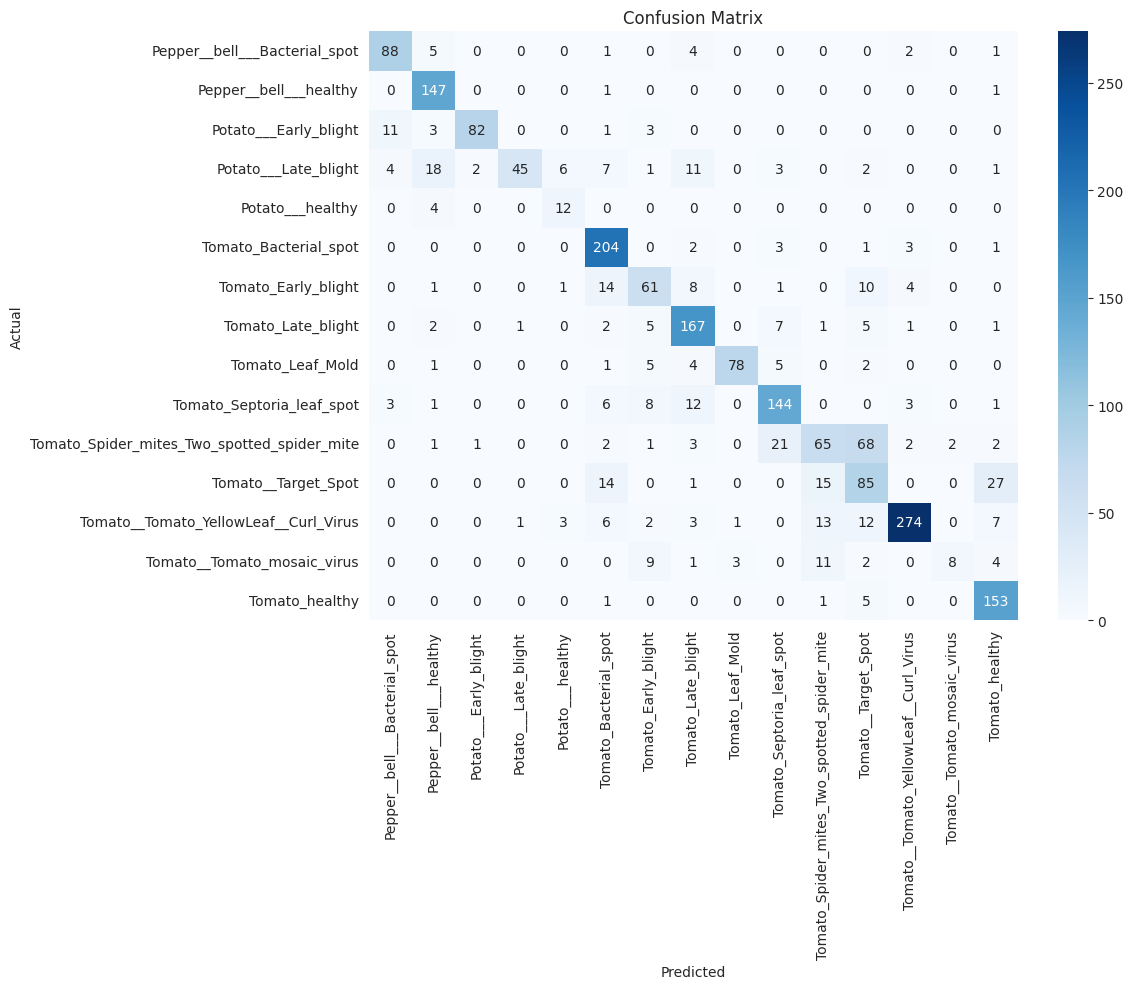

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


data_dir = "../data_split"

val_dataset = datasets.ImageFolder(
    root=f"{data_dir}/test",
    transform=val_transforms
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

class_names = val_dataset.classes
print("Classes:", class_names)


model.eval()

predictions = []
actuals = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        predictions.extend(preds.cpu().numpy())
        actuals.extend(labels.cpu().numpy())


acc = accuracy_score(actuals, predictions)
print(f"\nValidation Accuracy: {acc * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(actuals, predictions, target_names=class_names))


cm = confusion_matrix(actuals, predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [1]:
import torch
from torchvision.models import mobilenet_v3_small
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


num_classes = 15
model = mobilenet_v3_small(num_classes=num_classes)
model.eval()


checkpoint_path = "../mobilenetv3_stage1.pth"
checkpoint = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(checkpoint)


val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

data_dir = "../data_split"

val_dataset = datasets.ImageFolder(
    root=f"{data_dir}/val",
    transform=val_transforms
)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


example_input, _ = next(iter(val_loader))


onnx_path = "mobilenetv3_stage1.onnx"

torch.onnx.export(
    model,
    example_input,
    onnx_path,
    export_params=True,
    opset_version=18,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
    verbose=True
)

print(f"ONNX model exported successfully to {onnx_path}")


/tmp/ipykernel_21588/1324903661.py:39: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(


[torch.onnx] Obtain model graph for `MobileNetV3([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `MobileNetV3([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 68 of general pattern rewrite rules.
ONNX model exported successfully to mobilenetv3_stage1.onnx


In [1]:
import onnx
from onnx2tf import convert
import tensorflow as tf


onnx_model_path = "mobilenetv3_stage1.onnx"
tf_saved_model_dir = "mobilenetv3_tf_saved_model"
tflite_model_path = "mobilenetv3_stage1.tflite"


convert(
    input_onnx_file_path=onnx_model_path,
    output_folder_path=tf_saved_model_dir
)



converter = tf.lite.TFLiteConverter.from_saved_model(tf_saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)
print(f"TFLite model saved at: {tflite_model_path}")



Model optimizing started ============================================================
Traceback (most recent call last):
  File "/home/abdulaziz/AgriWatchAI/.venv/lib/python3.12/site-packages/onnx2tf/onnx2tf.py", line 716, in convert
    result = subprocess.check_output(
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/subprocess.py", line 466, in check_output
    return run(*popenargs, stdout=PIPE, timeout=timeout, check=True,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/usr/lib/python3.12/subprocess.py", line 1955, in _execute_child
    raise child_exception_type(errno_num, err_msg, err_filename)
FileNotFoundError: [Errno 2] No such file or directory: 'onnxsim

I0000 00:00:1768854602.995298   23305 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1768854602.995468   23305 single_machine.cc:376] Starting new session
W0000 00:00:1768854603.275270   23305 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1768854603.275294   23305 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
I0000 00:00:1768854603.623015   23305 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1768854603.623113   23305 single_machine.cc:376] Starting new session


Float32 tflite output complete!


W0000 00:00:1768854603.912369   23305 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1768854603.912393   23305 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.


Float16 tflite output complete!
TFLite model saved at: mobilenetv3_stage1.tflite


W0000 00:00:1768854605.243051   23305 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1768854605.243073   23305 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
I0000 00:00:1768854605.261491   23305 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled


Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']

Validation Accuracy (TFLite float16): 92.10%

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.95      0.93      0.94       101
                     Pepper__bell___healthy       0.96      0.99      0.98       149
                      Potato___Early_blight       1.00      0.96      0.98       100
                       Potato___Late_blight       0.81      0.98      0.89       100
                           Potato___healthy       1.00      1.00      1.00        16
  

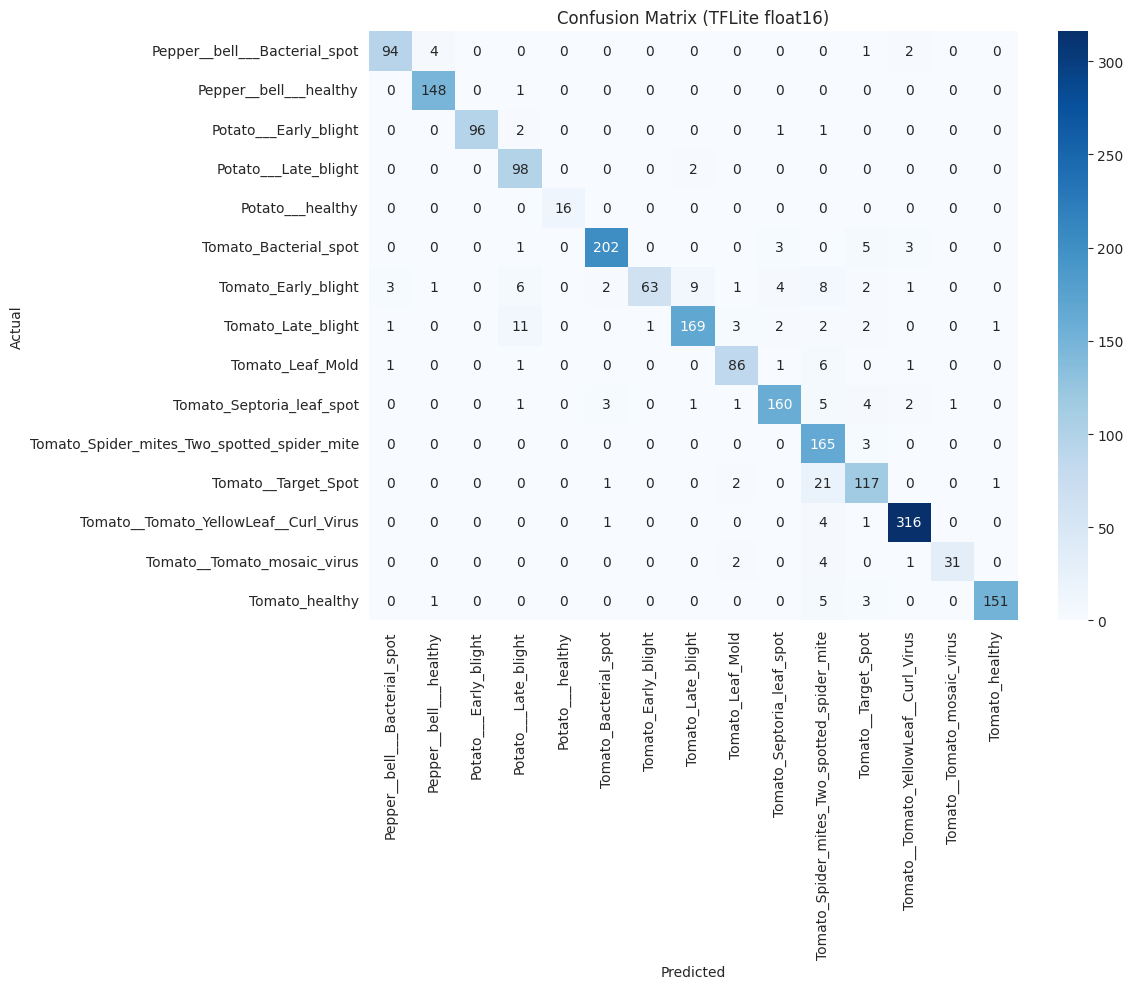

In [3]:
import numpy as np
import tensorflow as tf
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


tflite_model_path = "/home/abdulaziz/AgriWatchAI/notebook/mobilenetv3_tf_saved_model/mobilenetv3_stage1_float16.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

data_dir = "../data_split"
val_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=val_transforms)
val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

class_names = val_dataset.classes
print("Classes:", class_names)


predictions = []
actuals = []

for images, labels in val_loader:

    img = images.numpy().transpose(0, 2, 3, 1).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    preds = np.argmax(output, axis=1)

    predictions.extend(preds)
    actuals.extend(labels.numpy())


acc = accuracy_score(actuals, predictions)
print(f"\nValidation Accuracy (TFLite float16): {acc*100:.2f}%\n")

print("Classification Report:")
print(classification_report(actuals, predictions, target_names=class_names))

cm = confusion_matrix(actuals, predictions)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (TFLite float16)")
plt.tight_layout()
plt.show()
